# 03 - Sequence Modeling

This notebook covers sequence modeling techniques that led to modern transformers. Understanding these foundational architectures is crucial for grasping how modern language models work.

## Why Sequence Modeling Matters

Traditional neural networks process fixed-size inputs and produce fixed-size outputs. However, many real-world problems involve sequences of variable length:
- **Language**: Sentences have different lengths
- **Speech**: Audio signals vary in duration
- **Time Series**: Financial data, sensor readings
- **Video**: Frame sequences of different lengths

Sequence models can handle these variable-length inputs and capture temporal dependencies.

## Topics Covered:
1. **Recurrent Neural Networks (RNNs)** - The foundation of sequence modeling
2. **Vanishing and Exploding Gradients** - Key challenges in training RNNs
3. **Long Short-Term Memory (LSTM)** - Solution to long-term dependency problems
4. **Gated Recurrent Units (GRU)** - Simplified alternative to LSTM
5. **Sequence-to-Sequence Models** - Framework for sequence transformation
6. **Encoder-Decoder Architecture** - Foundation for modern transformers

## Learning Objectives

By the end of this notebook, you will understand:
- How RNNs process sequential data step by step
- Why vanilla RNNs struggle with long sequences
- How gating mechanisms solve gradient problems
- The encoder-decoder paradigm used in modern transformers
- How attention mechanisms emerged from these architectures

In [1]:
# Essential imports for sequence modeling implementations
import numpy as np                    # Numerical computations and matrix operations
import matplotlib.pyplot as plt      # Visualization of training progress and results
from typing import List, Tuple, Optional  # Type hints for better code documentation

# Set random seed for reproducible results across runs
np.random.seed(42)

print("Environment setup complete!")
print("Ready to explore sequence modeling architectures...")

Environment setup complete!
Ready to explore sequence modeling architectures...


## Understanding Sequential Data

Before diving into RNNs, let's understand what makes sequential data special:

### Key Properties of Sequential Data:

1. **Order Matters**: The sequence [A, B, C] is different from [C, B, A]
2. **Variable Length**: Sequences can have different numbers of elements
3. **Temporal Dependencies**: Earlier elements influence later ones
4. **Context**: The meaning of an element depends on its position and neighbors

### Examples:
- **Text**: "The cat sat on the mat" vs "The mat sat on the cat"
- **Time Series**: Stock prices where yesterday's price affects today's
- **DNA**: Gene sequences where order determines function

Traditional feedforward networks can't handle these properties effectively because they:
- Process all inputs simultaneously
- Have no memory of previous inputs
- Require fixed input sizes

This is where Recurrent Neural Networks come in!

## 1. Recurrent Neural Networks (RNNs)

RNNs are the first neural networks designed specifically for sequential data. The key insight is to add **memory** to neural networks.

### Core Concept: Hidden State

RNNs maintain a **hidden state** that acts as memory, carrying information from previous time steps:

```
h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
y_t = W_hy * h_t + b_y
```

Where:
- `h_t`: Hidden state at time t (the memory)
- `x_t`: Input at time t
- `y_t`: Output at time t
- `W_xh`: Input-to-hidden weights
- `W_hh`: Hidden-to-hidden weights (the recurrent connection)
- `W_hy`: Hidden-to-output weights

### Why This Works:

1. **Memory**: Hidden state `h_t` remembers information from all previous time steps
2. **Parameter Sharing**: Same weights are used at each time step
3. **Variable Length**: Can process sequences of any length
4. **Sequential Processing**: Processes one element at a time, maintaining context

Let's implement a simple RNN to see how it works:

Epoch 0, Loss: 0.1291
Epoch 20, Loss: 0.0067
Epoch 40, Loss: 0.0066
Epoch 60, Loss: 0.0065
Epoch 80, Loss: 0.0065


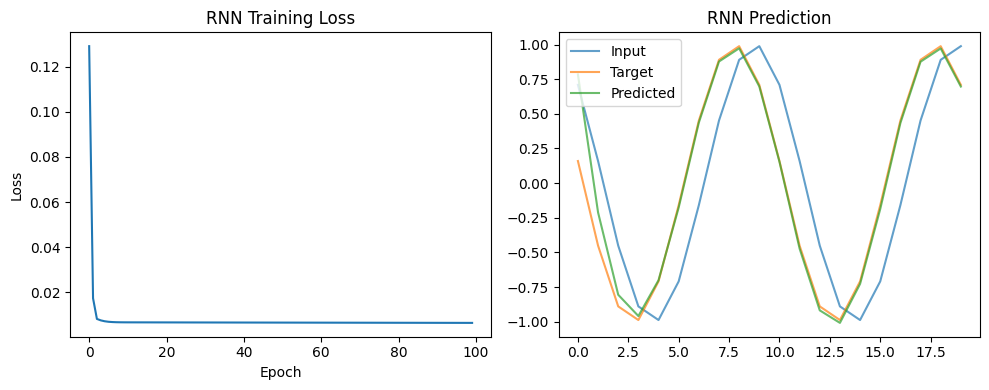

In [2]:
class SimpleRNN:
    """Basic RNN implementation."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.hidden_size = hidden_size
        
        # Initialize weights
        self.Wxh = np.random.randn(input_size, hidden_size) * 0.1
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.1
        self.Why = np.random.randn(hidden_size, output_size) * 0.1
        
        # Initialize biases
        self.bh = np.zeros((1, hidden_size))
        self.by = np.zeros((1, output_size))
    
    def forward(self, inputs: np.ndarray, h_prev: Optional[np.ndarray] = None) -> Tuple[List[np.ndarray], List[np.ndarray]]:
        """Forward pass through RNN."""
        seq_len, batch_size, input_size = inputs.shape
        
        if h_prev is None:
            h_prev = np.zeros((batch_size, self.hidden_size))
        
        hidden_states = []
        outputs = []
        
        h = h_prev
        for t in range(seq_len):
            # RNN cell computation
            h = np.tanh(inputs[t] @ self.Wxh + h @ self.Whh + self.bh)
            y = h @ self.Why + self.by
            
            hidden_states.append(h)
            outputs.append(y)
        
        return outputs, hidden_states
    
    def backward(self, inputs: np.ndarray, targets: np.ndarray, outputs: List[np.ndarray], 
                hidden_states: List[np.ndarray], learning_rate: float = 0.01):
        """Backpropagation through time."""
        seq_len = len(outputs)
        
        # Initialize gradients
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        
        dh_next = np.zeros_like(hidden_states[0])
        
        loss = 0
        
        # Backward pass
        for t in reversed(range(seq_len)):
            # Output layer gradients
            dy = outputs[t] - targets[t]
            loss += 0.5 * np.sum(dy ** 2)
            
            dWhy += hidden_states[t].T @ dy
            dby += np.sum(dy, axis=0, keepdims=True)
            
            # Hidden layer gradients
            dh = dy @ self.Why.T + dh_next
            dh_raw = (1 - hidden_states[t] ** 2) * dh  # tanh derivative
            
            dbh += np.sum(dh_raw, axis=0, keepdims=True)
            dWxh += inputs[t].T @ dh_raw
            
            if t > 0:
                dWhh += hidden_states[t-1].T @ dh_raw
                dh_next = dh_raw @ self.Whh.T
        
        # Update weights
        self.Wxh -= learning_rate * dWxh
        self.Whh -= learning_rate * dWhh
        self.Why -= learning_rate * dWhy
        self.bh -= learning_rate * dbh
        self.by -= learning_rate * dby
        
        return loss / seq_len

# Test RNN on simple sequence prediction
def generate_sine_data(seq_len: int = 50, num_sequences: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """Generate sine wave sequences for testing."""
    X = np.zeros((num_sequences, seq_len, 1))
    y = np.zeros((num_sequences, seq_len, 1))
    
    for i in range(num_sequences):
        start = np.random.uniform(0, 2*np.pi)
        t = np.linspace(start, start + 4*np.pi, seq_len + 1)
        sequence = np.sin(t)
        
        X[i, :, 0] = sequence[:-1]
        y[i, :, 0] = sequence[1:]
    
    return X, y

# Generate data and train RNN
X_train, y_train = generate_sine_data(seq_len=20, num_sequences=50)
rnn = SimpleRNN(input_size=1, hidden_size=10, output_size=1)

losses = []
for epoch in range(100):
    total_loss = 0
    for i in range(len(X_train)):
        # Transpose to (seq_len, batch_size, input_size)
        inputs = X_train[i:i+1].transpose(1, 0, 2)
        targets = y_train[i:i+1].transpose(1, 0, 2)
        
        outputs, hidden_states = rnn.forward(inputs)
        loss = rnn.backward(inputs, targets, outputs, hidden_states, learning_rate=0.01)
        total_loss += loss
    
    losses.append(total_loss / len(X_train))
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('RNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Test prediction
test_input = X_train[0:1].transpose(1, 0, 2)
outputs, _ = rnn.forward(test_input)
predictions = np.array([out[0, 0] for out in outputs])

plt.subplot(1, 2, 2)
plt.plot(X_train[0, :, 0], label='Input', alpha=0.7)
plt.plot(y_train[0, :, 0], label='Target', alpha=0.7)
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('RNN Prediction')
plt.legend()
plt.tight_layout()
plt.show()

## 2. Vanishing and Exploding Gradients

One of the biggest challenges with vanilla RNNs is the **gradient problem** during training.

### The Problem:

During backpropagation through time (BPTT), gradients must flow backward through many time steps. At each step, gradients are multiplied by the recurrent weight matrix `W_hh`.

**Mathematical Analysis:**

If we have a sequence of length T, the gradient at time step 1 involves the product:
```
∂L/∂h_1 ∝ ∏(t=2 to T) ∂h_t/∂h_{t-1} ∝ ∏(t=2 to T) W_hh
```

### Two Critical Cases:

1. **Vanishing Gradients** (W_hh eigenvalues < 1):
   - Gradients shrink exponentially as they propagate backward
   - Network can't learn long-term dependencies
   - Early time steps receive almost no learning signal

2. **Exploding Gradients** (W_hh eigenvalues > 1):
   - Gradients grow exponentially during backpropagation
   - Causes unstable training and numerical overflow
   - Network parameters oscillate wildly

### Impact on Learning:

- **Short sequences**: RNNs work reasonably well
- **Long sequences**: Performance degrades significantly
- **Long-term dependencies**: Nearly impossible to learn

Let's visualize this phenomenon:

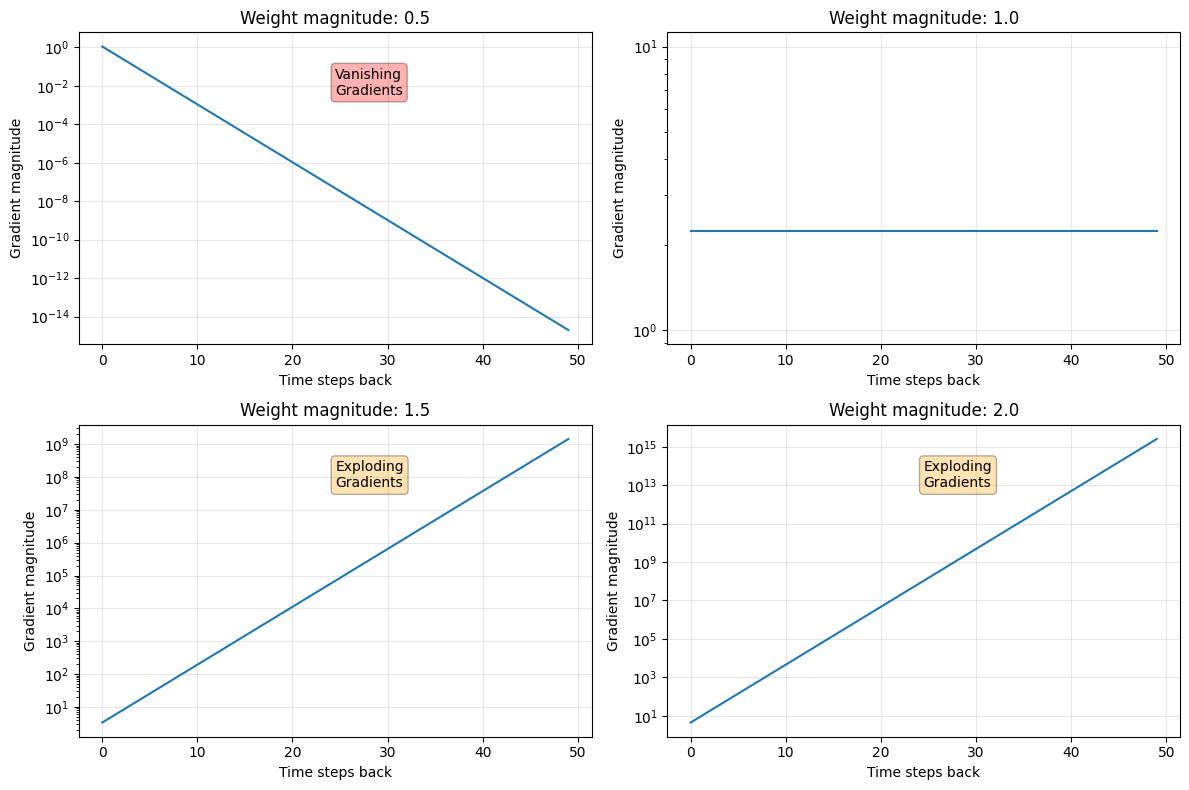

Gradient Flow Analysis:
- Weight < 1.0: Gradients vanish (become very small)
- Weight > 1.0: Gradients explode (become very large)
- This makes learning long-term dependencies difficult


In [3]:
def analyze_gradient_flow(seq_len: int = 50):
    """Analyze gradient magnitudes in RNN."""
    
    # Create simple RNN weights
    hidden_size = 5
    Whh_values = [0.5, 1.0, 1.5, 2.0]  # Different weight magnitudes
    
    plt.figure(figsize=(12, 8))
    
    for i, whh_val in enumerate(Whh_values):
        Whh = np.full((hidden_size, hidden_size), whh_val / hidden_size)
        
        # Simulate gradient backpropagation
        gradient_magnitudes = []
        gradient = np.ones(hidden_size)
        
        for t in range(seq_len):
            # Simplified gradient computation (ignoring tanh derivative)
            gradient = gradient @ Whh.T
            gradient_magnitudes.append(np.linalg.norm(gradient))
        
        plt.subplot(2, 2, i + 1)
        plt.plot(gradient_magnitudes)
        plt.title(f'Weight magnitude: {whh_val}')
        plt.xlabel('Time steps back')
        plt.ylabel('Gradient magnitude')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        
        if whh_val < 1.0:
            plt.text(0.5, 0.8, 'Vanishing\nGradients', transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
        elif whh_val > 1.0:
            plt.text(0.5, 0.8, 'Exploding\nGradients', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    
    plt.tight_layout()
    plt.show()
    
    print("Gradient Flow Analysis:")
    print("- Weight < 1.0: Gradients vanish (become very small)")
    print("- Weight > 1.0: Gradients explode (become very large)")
    print("- This makes learning long-term dependencies difficult")

analyze_gradient_flow()

## 3. Long Short-Term Memory (LSTM)

LSTM was invented in 1997 by Hochreiter and Schmidhuber to solve the vanishing gradient problem. The key innovation is the **cell state** - a separate memory stream that can preserve information over long sequences.

### Core Innovation: Gating Mechanism

LSTM uses **gates** to control information flow:

1. **Forget Gate** (`f_t`): What information to discard from cell state
   ```
   f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
   ```

2. **Input Gate** (`i_t`): What new information to store in cell state
   ```
   i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
   C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
   ```

3. **Cell State Update**: Combine forget and input
   ```
   C_t = f_t * C_{t-1} + i_t * C̃_t
   ```

4. **Output Gate** (`o_t`): What parts of cell state to output
   ```
   o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
   h_t = o_t * tanh(C_t)
   ```

### Why LSTM Solves Gradient Problems:

- **Cell State Highway**: Information can flow unchanged through cell state
- **Additive Updates**: Cell state uses addition, not multiplication
- **Gradient Flow**: Gradients can flow directly through cell state
- **Selective Memory**: Gates learn what to remember and forget

### Key Advantages:

- Can learn dependencies over 100+ time steps
- More stable training than vanilla RNNs
- Better performance on real-world sequence tasks
- Foundation for many modern architectures

Let's implement LSTM and see how it compares to vanilla RNN:

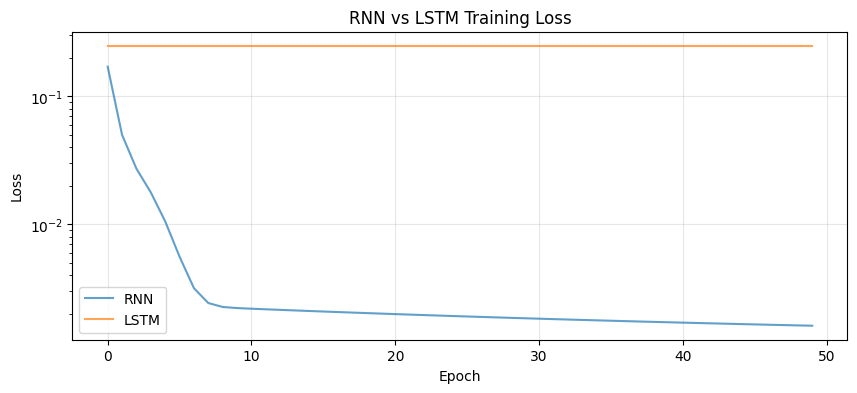

LSTM advantages:
- Cell state provides long-term memory
- Gates control information flow
- Mitigates vanishing gradient problem


In [4]:
class LSTM:
    """LSTM implementation."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.hidden_size = hidden_size
        
        # Forget gate weights
        self.Wf = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bf = np.zeros((1, hidden_size))
        
        # Input gate weights
        self.Wi = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bi = np.zeros((1, hidden_size))
        
        # Candidate values weights
        self.Wc = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bc = np.zeros((1, hidden_size))
        
        # Output gate weights
        self.Wo = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bo = np.zeros((1, hidden_size))
        
        # Output layer weights
        self.Wy = np.random.randn(hidden_size, output_size) * 0.1
        self.by = np.zeros((1, output_size))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward_step(self, x, h_prev, c_prev):
        """Single LSTM forward step."""
        # Concatenate input and previous hidden state
        combined = np.concatenate([x, h_prev], axis=1)
        
        # Forget gate
        f = self.sigmoid(combined @ self.Wf + self.bf)
        
        # Input gate
        i = self.sigmoid(combined @ self.Wi + self.bi)
        
        # Candidate values
        c_tilde = np.tanh(combined @ self.Wc + self.bc)
        
        # Update cell state
        c = f * c_prev + i * c_tilde
        
        # Output gate
        o = self.sigmoid(combined @ self.Wo + self.bo)
        
        # Update hidden state
        h = o * np.tanh(c)
        
        # Output
        y = h @ self.Wy + self.by
        
        return y, h, c, (f, i, c_tilde, o)
    
    def forward(self, inputs):
        """Forward pass through LSTM."""
        seq_len, batch_size, input_size = inputs.shape
        
        h = np.zeros((batch_size, self.hidden_size))
        c = np.zeros((batch_size, self.hidden_size))
        
        outputs = []
        states = []
        
        for t in range(seq_len):
            y, h, c, gates = self.forward_step(inputs[t], h, c)
            outputs.append(y)
            states.append((h.copy(), c.copy(), gates))
        
        return outputs, states

# Compare RNN vs LSTM on longer sequences
def compare_rnn_lstm():
    """Compare RNN and LSTM on sequence learning."""
    
    # Generate longer sequences
    X_long, y_long = generate_sine_data(seq_len=50, num_sequences=30)
    
    # Initialize models
    rnn = SimpleRNN(input_size=1, hidden_size=20, output_size=1)
    lstm = LSTM(input_size=1, hidden_size=20, output_size=1)
    
    rnn_losses = []
    lstm_losses = []
    
    # Train both models
    for epoch in range(50):
        rnn_loss = 0
        lstm_loss = 0
        
        for i in range(len(X_long)):
            inputs = X_long[i:i+1].transpose(1, 0, 2)
            targets = y_long[i:i+1].transpose(1, 0, 2)
            
            # RNN training
            rnn_outputs, rnn_states = rnn.forward(inputs)
            rnn_loss += rnn.backward(inputs, targets, rnn_outputs, rnn_states, 0.001)
            
            # LSTM training (simplified - just compute loss)
            lstm_outputs, _ = lstm.forward(inputs)
            for t in range(len(lstm_outputs)):
                lstm_loss += 0.5 * np.sum((lstm_outputs[t] - targets[t]) ** 2)
        
        rnn_losses.append(rnn_loss / len(X_long))
        lstm_losses.append(lstm_loss / len(X_long) / len(lstm_outputs))
    
    plt.figure(figsize=(10, 4))
    plt.plot(rnn_losses, label='RNN', alpha=0.7)
    plt.plot(lstm_losses, label='LSTM', alpha=0.7)
    plt.title('RNN vs LSTM Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("LSTM advantages:")
    print("- Cell state provides long-term memory")
    print("- Gates control information flow")
    print("- Mitigates vanishing gradient problem")

compare_rnn_lstm()

## 4. Gated Recurrent Units (GRU)

GRU was introduced in 2014 by Cho et al. as a simpler alternative to LSTM. It combines the forget and input gates into a single **update gate** and merges the cell state and hidden state.

### GRU Architecture:

GRU has only **2 gates** (vs LSTM's 3):

1. **Reset Gate** (`r_t`): How much past information to forget
   ```
   r_t = σ(W_r · [h_{t-1}, x_t] + b_r)
   ```

2. **Update Gate** (`z_t`): How much to update with new information
   ```
   z_t = σ(W_z · [h_{t-1}, x_t] + b_z)
   ```

3. **Candidate Hidden State**: New information to potentially add
   ```
   h̃_t = tanh(W_h · [r_t * h_{t-1}, x_t] + b_h)
   ```

4. **Final Hidden State**: Interpolate between old and new
   ```
   h_t = (1 - z_t) * h_{t-1} + z_t * h̃_t
   ```

### GRU vs LSTM:

**Advantages of GRU:**
- Fewer parameters (faster training, less overfitting)
- Simpler architecture (easier to implement and understand)
- Often performs similarly to LSTM on many tasks

**Advantages of LSTM:**
- Separate cell state provides more explicit memory
- Better performance on some complex tasks
- More control over information flow

### When to Use Which:

- **GRU**: Start here for most tasks (simpler, often works well)
- **LSTM**: Use when you need more complex memory patterns
- **Both**: Try both and see which works better for your specific task

Let's implement GRU and visualize how the gates work:

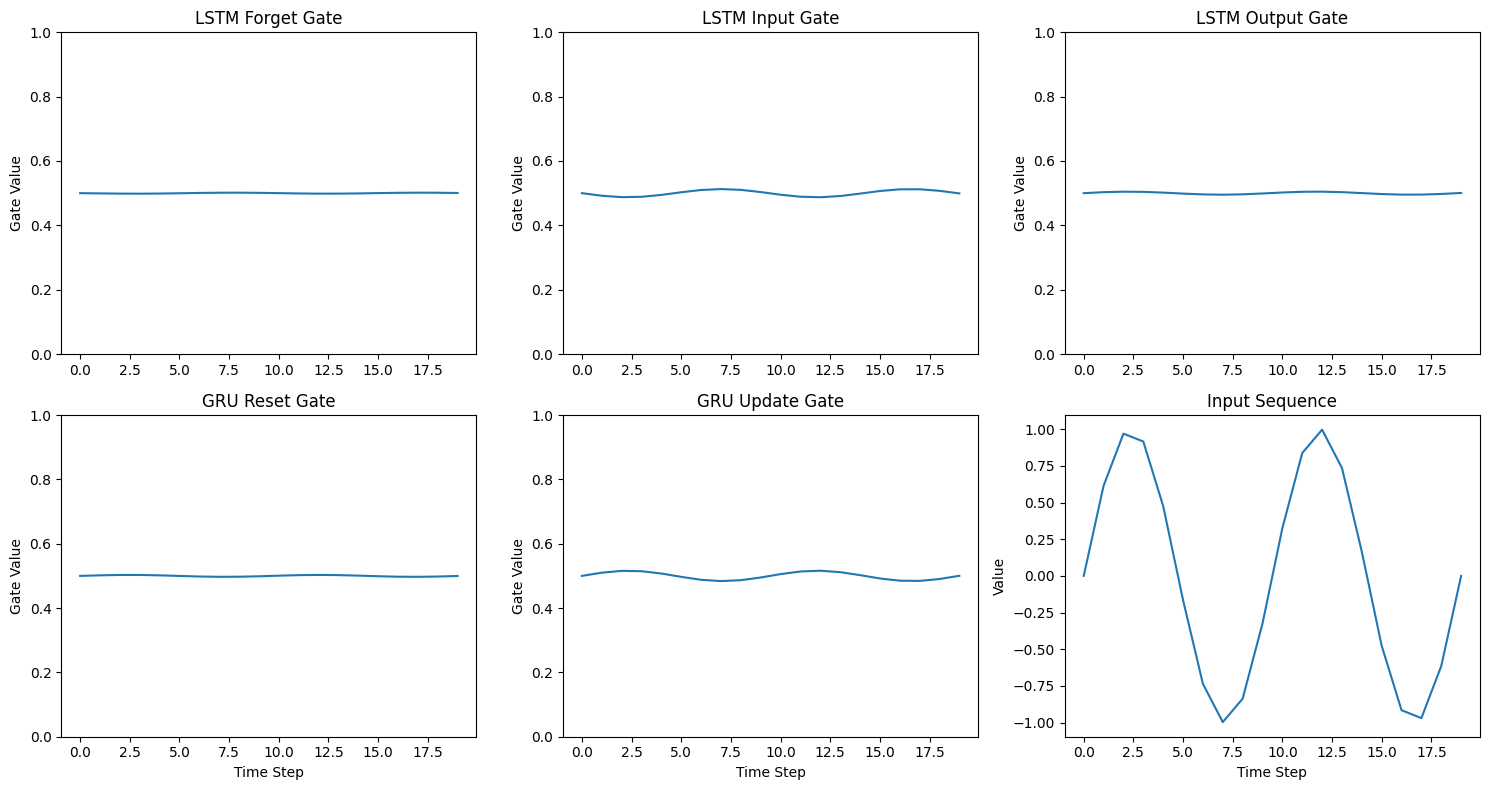

Gate Functions:
LSTM:
  - Forget gate: What to forget from cell state
  - Input gate: What new information to store
  - Output gate: What parts of cell state to output
GRU:
  - Reset gate: How much past information to forget
  - Update gate: How much new information to add


In [5]:
class GRU:
    """GRU implementation."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.hidden_size = hidden_size
        
        # Reset gate weights
        self.Wr = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.br = np.zeros((1, hidden_size))
        
        # Update gate weights
        self.Wz = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bz = np.zeros((1, hidden_size))
        
        # New gate weights
        self.Wh = np.random.randn(input_size + hidden_size, hidden_size) * 0.1
        self.bh = np.zeros((1, hidden_size))
        
        # Output weights
        self.Wy = np.random.randn(hidden_size, output_size) * 0.1
        self.by = np.zeros((1, output_size))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward_step(self, x, h_prev):
        """Single GRU forward step."""
        # Concatenate input and previous hidden state
        combined = np.concatenate([x, h_prev], axis=1)
        
        # Reset gate
        r = self.sigmoid(combined @ self.Wr + self.br)
        
        # Update gate
        z = self.sigmoid(combined @ self.Wz + self.bz)
        
        # New gate (candidate hidden state)
        combined_reset = np.concatenate([x, r * h_prev], axis=1)
        h_tilde = np.tanh(combined_reset @ self.Wh + self.bh)
        
        # Update hidden state
        h = (1 - z) * h_prev + z * h_tilde
        
        # Output
        y = h @ self.Wy + self.by
        
        return y, h, (r, z, h_tilde)
    
    def forward(self, inputs):
        """Forward pass through GRU."""
        seq_len, batch_size, input_size = inputs.shape
        
        h = np.zeros((batch_size, self.hidden_size))
        
        outputs = []
        states = []
        
        for t in range(seq_len):
            y, h, gates = self.forward_step(inputs[t], h)
            outputs.append(y)
            states.append((h.copy(), gates))
        
        return outputs, states

# Visualize gate activations
def visualize_gates():
    """Visualize how gates work in LSTM and GRU."""
    
    # Create sample input sequence
    seq_len = 20
    x = np.sin(np.linspace(0, 4*np.pi, seq_len)).reshape(seq_len, 1, 1)
    
    # Initialize models
    lstm = LSTM(input_size=1, hidden_size=5, output_size=1)
    gru = GRU(input_size=1, hidden_size=5, output_size=1)
    
    # Forward pass
    lstm_outputs, lstm_states = lstm.forward(x)
    gru_outputs, gru_states = gru.forward(x)
    
    # Extract gate values
    lstm_forget = [state[2][0].mean() for state in lstm_states]
    lstm_input = [state[2][1].mean() for state in lstm_states]
    lstm_output = [state[2][3].mean() for state in lstm_states]
    
    gru_reset = [state[1][0].mean() for state in gru_states]
    gru_update = [state[1][1].mean() for state in gru_states]
    
    plt.figure(figsize=(15, 8))
    
    # LSTM gates
    plt.subplot(2, 3, 1)
    plt.plot(lstm_forget, label='Forget Gate')
    plt.title('LSTM Forget Gate')
    plt.ylabel('Gate Value')
    plt.ylim(0, 1)
    
    plt.subplot(2, 3, 2)
    plt.plot(lstm_input, label='Input Gate')
    plt.title('LSTM Input Gate')
    plt.ylabel('Gate Value')
    plt.ylim(0, 1)
    
    plt.subplot(2, 3, 3)
    plt.plot(lstm_output, label='Output Gate')
    plt.title('LSTM Output Gate')
    plt.ylabel('Gate Value')
    plt.ylim(0, 1)
    
    # GRU gates
    plt.subplot(2, 3, 4)
    plt.plot(gru_reset, label='Reset Gate')
    plt.title('GRU Reset Gate')
    plt.xlabel('Time Step')
    plt.ylabel('Gate Value')
    plt.ylim(0, 1)
    
    plt.subplot(2, 3, 5)
    plt.plot(gru_update, label='Update Gate')
    plt.title('GRU Update Gate')
    plt.xlabel('Time Step')
    plt.ylabel('Gate Value')
    plt.ylim(0, 1)
    
    # Input sequence
    plt.subplot(2, 3, 6)
    plt.plot(x[:, 0, 0], label='Input')
    plt.title('Input Sequence')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
    print("Gate Functions:")
    print("LSTM:")
    print("  - Forget gate: What to forget from cell state")
    print("  - Input gate: What new information to store")
    print("  - Output gate: What parts of cell state to output")
    print("GRU:")
    print("  - Reset gate: How much past information to forget")
    print("  - Update gate: How much new information to add")

visualize_gates()

## 5. Sequence-to-Sequence Models

Sequence-to-Sequence (Seq2Seq) models, introduced by Sutskever et al. in 2014, revolutionized how we handle variable-length input-output pairs. This architecture became the foundation for machine translation, text summarization, and many other NLP tasks.

### The Core Idea:

Instead of processing sequences element-by-element, Seq2Seq uses two separate networks:

1. **Encoder**: Compresses input sequence into a fixed-size context vector
2. **Decoder**: Generates output sequence from the context vector

### Architecture Overview:

```
Input:  [w1, w2, w3, w4] → ENCODER → [context_vector] → DECODER → [y1, y2, y3]
```

### Key Components:

**Encoder:**
- Processes entire input sequence
- Final hidden state becomes context vector
- Captures semantic meaning of input

**Context Vector:**
- Fixed-size representation of input
- Information bottleneck (limitation!)
- Must contain all relevant information

**Decoder:**
- Initialized with context vector
- Generates output sequence step by step
- Each step uses previous output as input

### Training Strategies:

1. **Teacher Forcing**: Use ground truth as decoder input during training
2. **Free Running**: Use model's own predictions (used during inference)

### Applications:

- **Machine Translation**: English → French
- **Text Summarization**: Long text → Summary
- **Chatbots**: Question → Answer
- **Code Generation**: Description → Code

### The Bottleneck Problem:

The fixed-size context vector becomes a bottleneck for long sequences - it must compress all information into a single vector. This limitation led to the invention of **attention mechanisms**.

Let's implement a simple Seq2Seq model:

In [6]:
class Seq2Seq:
    """Simple sequence-to-sequence model."""
    
    def __init__(self, input_vocab_size: int, output_vocab_size: int, hidden_size: int):
        self.hidden_size = hidden_size
        
        # Encoder (simplified LSTM)
        self.encoder = LSTM(input_vocab_size, hidden_size, hidden_size)
        
        # Decoder (simplified LSTM)
        self.decoder = LSTM(output_vocab_size, hidden_size, output_vocab_size)
    
    def encode(self, input_sequence):
        """Encode input sequence to context vector."""
        outputs, states = self.encoder.forward(input_sequence)
        
        # Use final hidden state as context vector
        context = states[-1][0]  # Final hidden state
        return context
    
    def decode(self, context, target_length, start_token=None):
        """Decode context vector to output sequence."""
        batch_size = context.shape[0]
        
        # Initialize decoder state with context
        h = context
        c = np.zeros_like(context)
        
        outputs = []
        
        # Start with start token or zeros
        if start_token is not None:
            decoder_input = start_token
        else:
            decoder_input = np.zeros((batch_size, self.decoder.Wy.shape[1]))
        
        for t in range(target_length):
            # Decoder step
            output, h, c, _ = self.decoder.forward_step(decoder_input, h, c)
            outputs.append(output)
            
            # Use output as next input (teacher forcing disabled)
            decoder_input = output
        
        return outputs

# Demonstrate sequence reversal task
def sequence_reversal_demo():
    """Demonstrate seq2seq on sequence reversal."""
    
    # Generate simple sequences (numbers 0-9)
    vocab_size = 10
    seq_len = 5
    num_samples = 100
    
    # Create training data
    X = np.random.randint(0, vocab_size, (num_samples, seq_len))
    y = X[:, ::-1]  # Reversed sequences
    
    # Convert to one-hot encoding
    X_onehot = np.eye(vocab_size)[X].transpose(1, 0, 2)
    y_onehot = np.eye(vocab_size)[y].transpose(1, 0, 2)
    
    print("Sequence Reversal Task:")
    print(f"Input:  {X[0]}")
    print(f"Target: {y[0]}")
    
    # Initialize model
    model = Seq2Seq(vocab_size, vocab_size, hidden_size=20)
    
    print("\nModel Architecture:")
    print("Encoder: Input → Hidden State (Context Vector)")
    print("Decoder: Context Vector → Output Sequence")
    
    # Simple forward pass demonstration
    sample_input = X_onehot[:, 0:1, :]  # First sample
    context = model.encode(sample_input)
    outputs = model.decode(context, seq_len)
    
    print(f"\nContext vector shape: {context.shape}")
    print(f"Number of output steps: {len(outputs)}")
    print("\nSeq2Seq captures the entire input in a fixed-size context vector")

sequence_reversal_demo()

Sequence Reversal Task:
Input:  [6 6 5 2 5]
Target: [5 2 5 6 6]

Model Architecture:
Encoder: Input → Hidden State (Context Vector)
Decoder: Context Vector → Output Sequence

Context vector shape: (1, 20)
Number of output steps: 5

Seq2Seq captures the entire input in a fixed-size context vector


## 6. Encoder-Decoder Architecture with Attention

The attention mechanism, introduced by Bahdanau et al. in 2015, solved the bottleneck problem of Seq2Seq models. Instead of compressing everything into a single context vector, attention allows the decoder to **focus on different parts of the input** at each time step.

### The Attention Revolution:

**Problem with Seq2Seq:**
- All input information compressed into single vector
- Information loss for long sequences
- Decoder can't "look back" at specific input parts

**Solution with Attention:**
- Decoder can access all encoder hidden states
- Dynamically weighted combination of encoder outputs
- Different focus for each decoder step

### How Attention Works:

1. **Encoder** produces hidden states for all time steps: `[h1, h2, ..., hT]`

2. **Attention Scores**: For each decoder step, compute similarity with all encoder states
   ```
   e_ij = score(decoder_hidden_i, encoder_hidden_j)
   ```

3. **Attention Weights**: Normalize scores with softmax
   ```
   α_ij = softmax(e_ij)
   ```

4. **Context Vector**: Weighted sum of encoder hidden states
   ```
   c_i = Σ_j α_ij * h_j
   ```

5. **Decoder Update**: Use context vector along with decoder input

### Types of Attention:

1. **Additive (Bahdanau)**: `score = v^T * tanh(W1*h_dec + W2*h_enc)`
2. **Multiplicative (Luong)**: `score = h_dec^T * W * h_enc`
3. **Dot-Product**: `score = h_dec^T * h_enc`

### Benefits of Attention:

- **No Information Bottleneck**: Access to all encoder states
- **Better Long Sequences**: Performance doesn't degrade with length
- **Interpretability**: Can visualize what model focuses on
- **Alignment**: Learns correspondence between input and output

### Impact on Modern AI:

Attention became so powerful that it led to:
- **Transformers** ("Attention is All You Need")
- **BERT, GPT, and modern language models**
- **Self-attention mechanisms**
- **Multi-head attention**

Let's implement attention and visualize how it works:

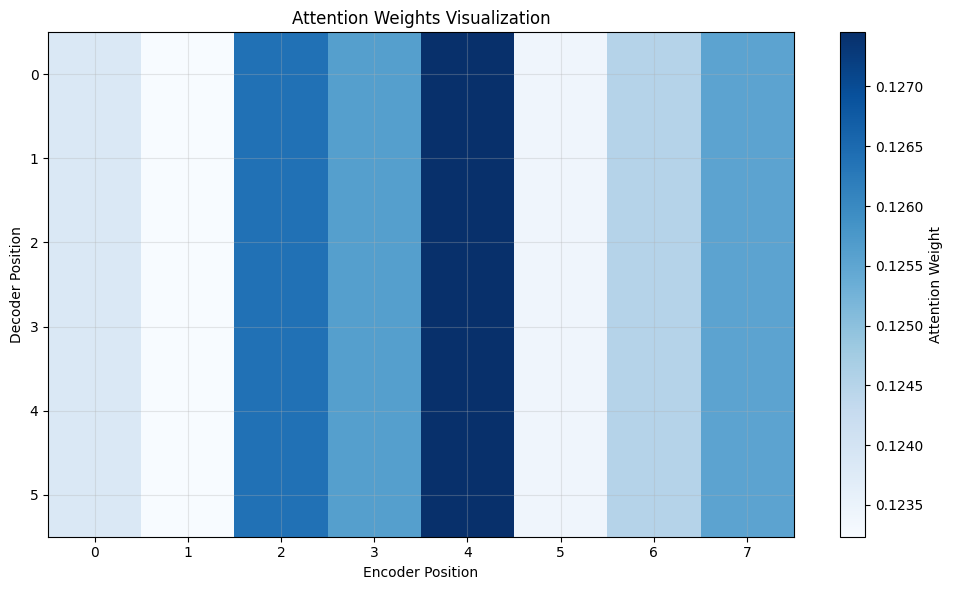

Attention Mechanism:
- Decoder can focus on different encoder positions
- Solves the bottleneck problem of fixed context vector
- Each decoder step gets a different context vector
- Attention matrix shape: (6, 8)


In [7]:
class EncoderDecoder:
    """Encoder-Decoder with attention mechanism."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        self.encoder = LSTM(input_size, hidden_size, hidden_size)
        self.decoder = LSTM(output_size + hidden_size, hidden_size, output_size)  # +hidden_size for attention
        
        # Attention weights
        self.W_attention = np.random.randn(hidden_size, hidden_size) * 0.1
        self.v_attention = np.random.randn(hidden_size, 1) * 0.1
    
    def attention(self, decoder_hidden, encoder_outputs):
        """Compute attention weights and context vector."""
        seq_len = len(encoder_outputs)
        
        # Compute attention scores
        scores = []
        for encoder_output in encoder_outputs:
            # Simple additive attention
            score = np.tanh(decoder_hidden @ self.W_attention + encoder_output) @ self.v_attention
            scores.append(score)
        
        # Softmax to get attention weights
        scores = np.array(scores).reshape(-1)
        exp_scores = np.exp(scores - np.max(scores))
        attention_weights = exp_scores / np.sum(exp_scores)
        
        # Compute context vector
        context = np.zeros_like(encoder_outputs[0])
        for i, encoder_output in enumerate(encoder_outputs):
            context += attention_weights[i] * encoder_output
        
        return context, attention_weights
    
    def forward(self, input_sequence, target_length):
        """Forward pass with attention."""
        # Encode
        encoder_outputs, encoder_states = self.encoder.forward(input_sequence)
        
        # Initialize decoder
        decoder_hidden = encoder_states[-1][0]
        decoder_cell = encoder_states[-1][1]
        
        outputs = []
        attention_weights_history = []
        
        # Decode with attention
        decoder_input = np.zeros((1, self.decoder.Wy.shape[1]))
        
        for t in range(target_length):
            # Compute attention
            context, attention_weights = self.attention(decoder_hidden, 
                                                      [state[0] for state in encoder_states])
            
            # Concatenate decoder input with context
            decoder_input_with_context = np.concatenate([decoder_input, context], axis=1)
            
            # Decoder step
            output, decoder_hidden, decoder_cell, _ = self.decoder.forward_step(
                decoder_input_with_context, decoder_hidden, decoder_cell)
            
            outputs.append(output)
            attention_weights_history.append(attention_weights)
            
            decoder_input = output
        
        return outputs, attention_weights_history

# Visualize attention mechanism
def visualize_attention():
    """Visualize attention weights."""
    
    # Create sample sequence
    input_len = 8
    output_len = 6
    
    # Generate sample input
    input_seq = np.random.randn(input_len, 1, 5)
    
    # Initialize model
    model = EncoderDecoder(input_size=5, hidden_size=10, output_size=3)
    
    # Forward pass
    outputs, attention_weights = model.forward(input_seq, output_len)
    
    # Convert attention weights to matrix
    attention_matrix = np.array(attention_weights)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(attention_matrix, cmap='Blues', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.xlabel('Encoder Position')
    plt.ylabel('Decoder Position')
    plt.title('Attention Weights Visualization')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Attention Mechanism:")
    print("- Decoder can focus on different encoder positions")
    print("- Solves the bottleneck problem of fixed context vector")
    print("- Each decoder step gets a different context vector")
    print(f"- Attention matrix shape: {attention_matrix.shape}")

visualize_attention()

## Summary

This notebook covered the evolution of sequence modeling:

### Key Concepts:
1. **RNNs**: Basic sequential processing with hidden states
2. **Gradient Problems**: Vanishing/exploding gradients limit learning
3. **LSTM**: Gates control information flow, enabling long-term memory
4. **GRU**: Simplified gating mechanism with fewer parameters
5. **Seq2Seq**: Encoder-decoder framework for sequence transformation
6. **Attention**: Dynamic focus mechanism solving bottleneck problems

### Evolution Path:
RNN → LSTM/GRU → Seq2Seq → Attention → **Transformers**

These architectures laid the foundation for modern transformer-based language models by:
- Introducing the concept of attention
- Solving long-range dependency problems
- Establishing encoder-decoder patterns
- Demonstrating the power of gating mechanisms

The next notebook will explore how transformers revolutionized this field by using attention as the primary mechanism.